In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
from IPython.display import display, clear_output
import torch.autograd.functional as autofunc
from torch.autograd.functional import jacobian
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from collections.abc import Iterable

import torch.optim as optim
from torch.autograd.functional import jacobian
from scipy.integrate import solve_ivp

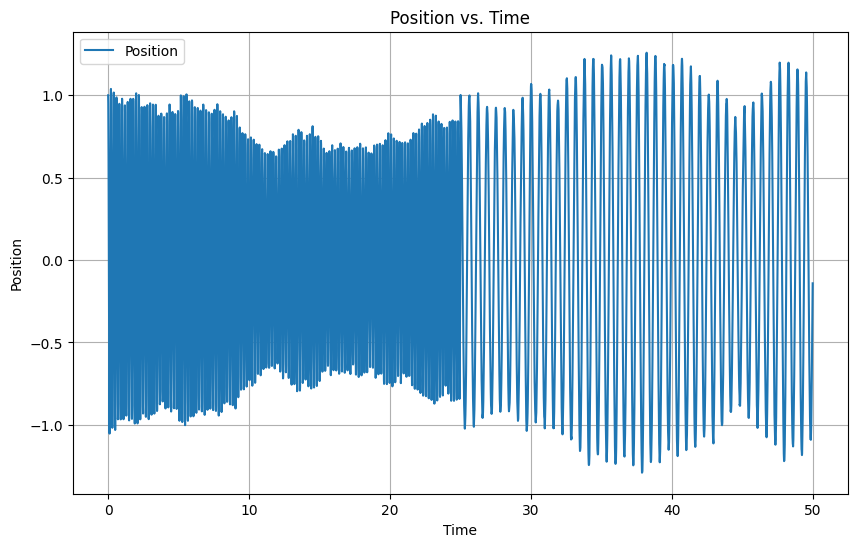

In [2]:
# Define the function representing the differential equation
def diff_eq(t, vector, sigma, mu, constant1, constant2):
    # y[0]: position, y[1]: velocity
    position_dot = vector[1]  # velocity
    velocity_dot = -constant1 * vector[0] - constant2 * vector[1] + sigma * np.random.randn() + mu # Example differential equation
    return np.array([position_dot, velocity_dot])

# Implement the fourth-order Runge-Kutta method
def runge_kutta_4th_order(f, t, y, dt):
    k1 = f(t, y)
    k2 = f(t + 0.5 * dt, y + 0.5 * dt * k1)
    k3 = f(t + 0.5 * dt, y + 0.5 * dt * k2)
    k4 = f(t + dt, y + dt * k3)
    return y + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

# Generate synthetic data using RK4 integration
def generate_data(diff_eq, t_span, y0, dt, sigma_phase1, mu_phase1, sigma_phase2, mu_phase2, constant1_phase1, constant2_phase1, constant1_phase2, constant2_phase2, delta):
    t_phase1 = np.arange(t_span[0], t_span[1] / 2, dt)
    t_phase2 = np.arange(t_span[1] / 2.0, t_span[1], dt)

    n_steps_phase1 = len(t_phase1)
    n_steps_phase2 = len(t_phase2)

    y_phase1 = np.zeros((n_steps_phase1, len(y0)))
    y_phase2 = np.zeros((n_steps_phase2, len(y0)))

    y_phase1[0] = y0
    y_phase2[0] = y0

    for i in range(1, n_steps_phase1):
        y_phase1[i] = runge_kutta_4th_order(lambda t, y: diff_eq(t, y, sigma_phase1, mu_phase1, constant1_phase1, constant2_phase1), t_phase1[i - 1], y_phase1[i - 1], dt) + delta * np.random.randn()

    for i in range(1, n_steps_phase2):
        y_phase2[i] = runge_kutta_4th_order(lambda t, y: diff_eq(t, y, sigma_phase2, mu_phase2, constant1_phase2, constant2_phase2), t_phase2[i - 1], y_phase2[i - 1], dt) + delta * np.random.randn()

    r1 = 1 + 0.1*np.random.randn((len(y_phase1)),2)
    r2 = 1 + 0.1*np.random.randn((len(y_phase2)),2)
    return np.concatenate((t_phase1, t_phase2)), np.concatenate((y_phase1, y_phase2))


# Example usage:
# Define initial conditions and time span
y0 = np.array([1.0, 0.0])  # initial position and velocity
t_span = (0.0, 50.0)  # time span
dt = 0.01  # time step

# Define parameters for phase 1 and phase 2
sigma_phase1 = 0.00
mu_phase1 = 0.0
constant1_phase1 = 1000.0
constant2_phase1 = 0.0

sigma_phase2 = 0.00
mu_phase2 = 0.0
constant1_phase2 = 100.0
constant2_phase2 = 0.0

# Define Delta noise in post
delta = 0.01

# Generate synthetic data
t, y = generate_data(diff_eq, t_span, y0, dt, sigma_phase1, mu_phase1, sigma_phase2, mu_phase2, constant1_phase1, constant2_phase1, constant1_phase2, constant2_phase2, delta)


# Plot position against time
plt.figure(figsize=(10, 6))
plt.plot(t[:], y[:, 0], label='Position')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Position vs. Time')
plt.grid(True)
plt.legend()
plt.show()

# adapt y to the network
y = y[:,0]
t_span = t_span[1]

In [3]:
class FeedForward(nn.Module):
  def __init__(self, pars):
    super(FeedForward, self).__init__()
    self.input_size = pars['input_size']
    self.hidden_size = pars['hidden_size']
    self.output_size = pars['output_size']
    self.n = pars['n_layers']
    self.act_type = pars['activation']

    if isinstance(self.hidden_size, Iterable) == False:
      self.hidden_size = [self.hidden_size] * self.n
    else:
      self.n = len(self.hidden_layers)

    if self.act_type == 'tanh':
      self.act = nn.Tanh()
    elif self.act_type == 'sig':
      self.act = nn.Sigmoid()
    elif self.act_type == 'relu':
      self.act = nn.ReLU()

    self.fci = nn.Linear(self.input_size, self.hidden_size[0])

    self.linear_list = torch.nn.ModuleList()
    for k in range(self.n -1):
      self.linear_list.append(torch.nn.Linear(self.hidden_size[k], self.hidden_size[k+1]))

    self.fcf = nn.Linear(self.hidden_size[-1], self.output_size)

  def forward(self, x):
    x = self.fci(x)
    for i in range(self.n -1):
      x = self.act(x)
      x = self.linear_list[i](x)
    x = self.act(x)
    x = self.fcf(x)
    return x

39
4960


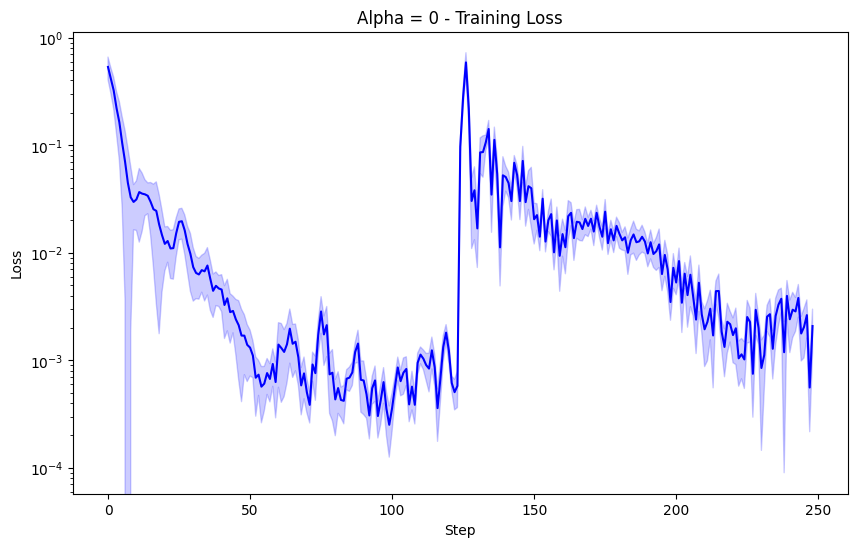

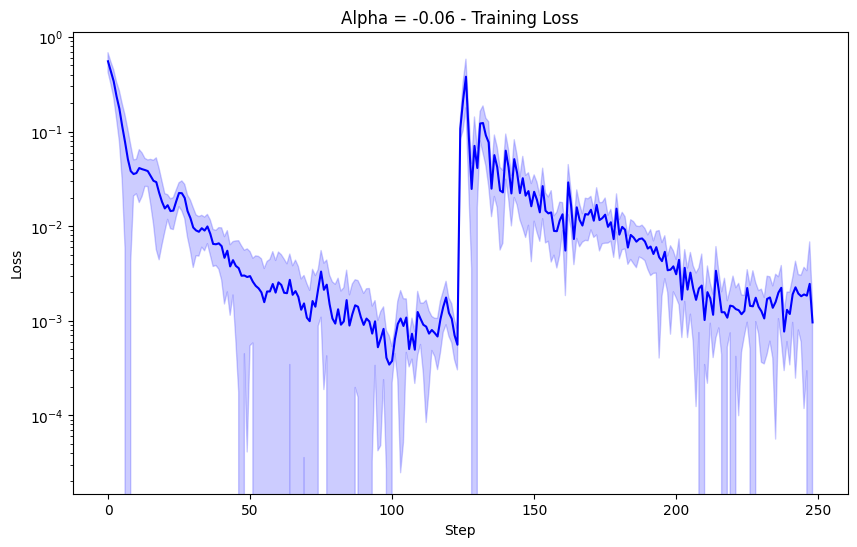

In [4]:
# Define hyperparameters
training_pars = {
    'input_size': 10,
    'hidden_size': 10,
    'output_size': 1,
    'optimizer': 'adam',
    'learning_rate': 0.01,
    'loss_func': 'mse',
    'batch_size': 20,
    'n_layers': 2,
    'activation': 'tanh'
}

alf = -0.06

model = FeedForward(training_pars)
# Function to save the initial weights of the model
def initialize_and_save_weights(training_pars):
    model = FeedForward(training_pars)
    initial_weights = model.state_dict()
    return initial_weights

# Function to initialize a model with specific weights
def initialize_model_with_weights(training_pars, initial_weights):
    model = FeedForward(training_pars)
    model.load_state_dict(initial_weights)
    return model

# Function to run training with a specific alpha value
def run_training(alpha, num_trainings=20):
    input_size = training_pars['input_size']
    output_size = training_pars['output_size']
    learning_rate = training_pars['learning_rate']
    batch_size = training_pars['batch_size']

    # Initialize placeholders for results
    length_lyapunov_loop = len(y) - input_size - batch_size
    lyapunov_mean_over_trainings_0 = np.zeros((num_trainings, 1 + length_lyapunov_loop // batch_size))
    losses_mean_over_trainings_0 = np.zeros((num_trainings, 1 + length_lyapunov_loop // batch_size))
    lyapunov_mean_over_trainings_alpha = np.zeros((num_trainings, 1 + length_lyapunov_loop // batch_size))
    losses_mean_over_trainings_alpha = np.zeros((num_trainings, 1 + length_lyapunov_loop // batch_size))

    for h in range(num_trainings*2):
        # Initialize model with the same initial weights
        if h%2 == 0:
            # Save the initial weights
            initial_weights = initialize_and_save_weights(training_pars)
            model = initialize_model_with_weights(training_pars, initial_weights)
        else:
            model = initialize_model_with_weights(training_pars, initial_weights)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Initialize lists for storing losses and Lyapunov exponents
        losses = []
        lyapunov_mean_list = []

        # Training loop
        for k in range(0, length_lyapunov_loop, batch_size):
            clear_output(wait=True)
            print(h)
            print(k)
            loss_mse = 0
            input_seq_step_lyapunov = (torch.rand(input_size, requires_grad=True) * 2.0 - torch.ones(input_size, requires_grad=True)).float().view(1, 1, input_size)
            jacobian_matrix = torch.zeros(input_size, input_size, batch_size)
            transposed_jacobian_matrix = torch.zeros(input_size, input_size, batch_size)

            for i in range(batch_size):
                input_seq_step = torch.tensor(y[k + i:k + i + input_size], requires_grad=True).float().view(1, 1, input_size)
                target_seq_step = torch.tensor(y[k + i + input_size: k + i + input_size + 1], requires_grad=True).float().view(1, 1, 1)
                output = model(input_seq_step)
                loss_mse += criterion(output, target_seq_step) / batch_size

            # Jacobian calculation
                jacobian_tensor = jacobian(model, input_seq_step_lyapunov, create_graph=True).view(input_size)
                jacobian_part_1 = jacobian_tensor.unsqueeze(0)
                jacobian_part_2 = torch.eye(input_size - 1).requires_grad_(True)
                jacobian_part_3 = torch.zeros(input_size - 1).requires_grad_(True).unsqueeze(0)
                concatenated_matrix = torch.cat((jacobian_part_2, jacobian_part_3), dim=0).T
                jacobian_matrix[:, :, i] = torch.cat((jacobian_part_1, concatenated_matrix), dim=0)
                transposed_jacobian_matrix[:, :, i] = jacobian_matrix[:, :, i].T.clone().requires_grad_(True)

                # Update input sequence for Lyapunov
                output_lyapunov = model(input_seq_step_lyapunov)
                input_seq_step_lyapunov = torch.cat([input_seq_step_lyapunov[:, :, 1:], output_lyapunov], dim=2).requires_grad_(True)

            # Compute the Lyapunov exponent
            jacobian_matrix_product = torch.linalg.multi_dot([jacobian_matrix[:, :, i] for i in range(batch_size)])
            transposed_jacobian_matrix_product = torch.linalg.multi_dot([transposed_jacobian_matrix[:, :, i] for i in range(batch_size)])
            Lambda = torch.matmul(jacobian_matrix_product, transposed_jacobian_matrix_product)
            eigenvalues = torch.linalg.eigvalsh(Lambda)
            lyapunov = torch.log(torch.abs(eigenvalues[-1])) / (2 * batch_size)
            lyapunov_mean_list.append(lyapunov.detach().numpy())

            # Compute combined loss
            if h%2 == 0:
                loss = loss_mse
                losses.append(loss.item())
            else:
                loss = loss_mse + alpha * lyapunov
                losses.append(loss.item() - alpha * np.abs(lyapunov.detach().numpy()))

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Store values for plotting
        if h%2 == 0:
            lyapunov_mean_over_trainings_0[int(h//2)] = lyapunov_mean_list
            losses_mean_over_trainings_0[int(h/2)] = losses
            weight_v = model.state_dict()
        else:
            lyapunov_mean_over_trainings_alpha[int(h/2)] = lyapunov_mean_list
            losses_mean_over_trainings_alpha[int(h/2)] = losses
            weight_l = model.state_dict()

    return lyapunov_mean_over_trainings_0, losses_mean_over_trainings_0, lyapunov_mean_over_trainings_alpha, losses_mean_over_trainings_alpha, weight_v, weight_l

# Run the cycle with alpha = -0.1
lyapunov_mean_over_trainings_0, losses_mean_over_trainings_0, lyapunov_mean_over_trainings_alpha, losses_mean_over_trainings_alpha, wv, wl = run_training(alpha=alf)
# Plot results
def plot_results(losses, lyapunov, title):
    mean_plot_lyapunov = np.mean(lyapunov, axis=0)
    std_plot_lyapunov = np.std(lyapunov, axis=0)
    mean_plot_loss = np.mean(losses, axis=0)
    std_plot_loss = np.std(losses, axis=0)

    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax1.set_yscale('log')
    ax1.plot(mean_plot_loss, color='b')
    ax1.fill_between(range(len(mean_plot_loss)), mean_plot_loss - std_plot_loss, mean_plot_loss + std_plot_loss, color='b', alpha=0.2)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(f'{title} - Training Loss')
    plt.show()

# Plot results for alpha = 0
plot_results(losses_mean_over_trainings_0, lyapunov_mean_over_trainings_0, "Alpha = 0")

# Plot results for alpha = -0.1
plot_results(losses_mean_over_trainings_alpha, lyapunov_mean_over_trainings_alpha, "Alpha = {n}".format(n = alf))


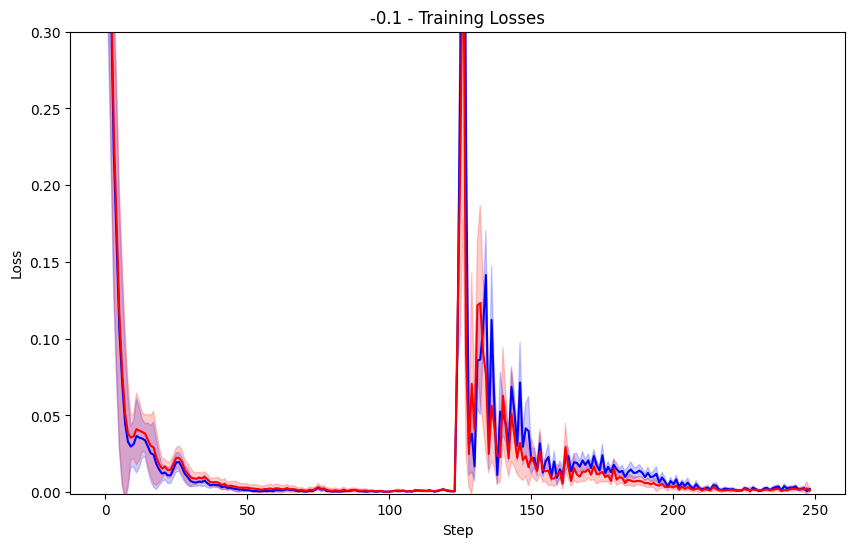

In [6]:
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
#ax1.set_yscale('log')

mean_plot_loss_0 = np.mean(losses_mean_over_trainings_0, axis=0)
std_plot_loss_0 = np.std(losses_mean_over_trainings_0, axis=0)
ax1.fill_between(range(len(mean_plot_loss_0)), mean_plot_loss_0 - std_plot_loss_0, mean_plot_loss_0 + std_plot_loss_0, color='b', alpha=0.2)
ax1.plot(mean_plot_loss_0, color='b')

mean_plot_loss_alpha = np.mean(losses_mean_over_trainings_alpha, axis=0)
std_plot_loss_alpha = np.std(losses_mean_over_trainings_alpha, axis=0)
ax1.plot(mean_plot_loss_alpha, color='r')
ax1.fill_between(range(len(mean_plot_loss_alpha)), mean_plot_loss_alpha - std_plot_loss_alpha, mean_plot_loss_alpha + std_plot_loss_alpha, color='r', alpha=0.2)

plt.xlabel('Step')
plt.ylabel('Loss')
plt.ylim(-0.001, 0.3)
plt.title(f'{-0.1} - Training Losses')
plt.show()

0.021971672254182104


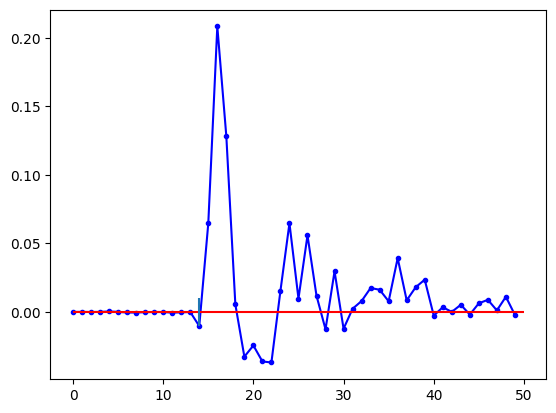

In [7]:
# Plot the loss
clear_output(wait=True)
fig, ax1 = plt.subplots()
#ax1.set_yscale('log')
n1 = 110
n2 = n1 + 50
ax1.plot(mean_plot_loss_0[n1:n2] - mean_plot_loss_alpha[n1:n2], '.-', color='b')
ax1.hlines(0, 0, n2-n1,color='r')
ax1.vlines(124-n1, -0.01, 0.01)
print(np.mean(mean_plot_loss_0[124:150] - mean_plot_loss_alpha[124:150]))
plt.show()

1.36296782751501


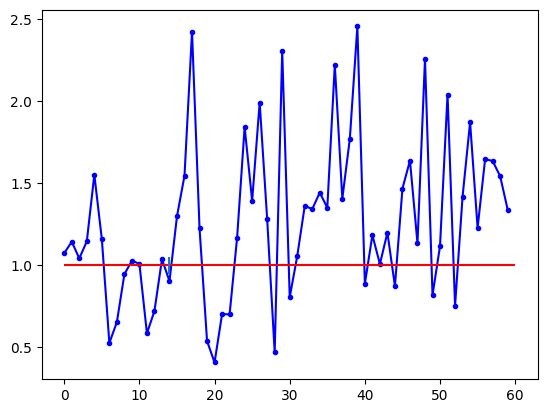

In [8]:
# Plot the loss
clear_output(wait=True)
fig, ax1 = plt.subplots()
#ax1.set_yscale('log')
n1 = 110
n2 = n1 + 60
ax1.plot(mean_plot_loss_0[n1:n2]/mean_plot_loss_alpha[n1:n2], '.-', color='b')
ax1.hlines(1, 0, n2-n1,color='r')
ax1.vlines(124-n1, 0.95, 1.05)

print(np.mean(mean_plot_loss_0[124:150]/mean_plot_loss_alpha[124:150]))
plt.show()

In [16]:
# Step 1 :Lorenz attractor function with dynamic parameters
def lorenz_lorenz(t, state, sigma1=10, beta1=8/3, rho1=28, sigma2=10, beta2=8/3, rho2=28, t_switch=5000):
    x, y, z = state
    if t < t_switch:
        sigma, beta, rho = sigma1, beta1, rho1
    else:
        sigma, beta, rho = sigma2, beta2, rho2
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]


def lorenz_rossler(t, state, sigma1=10, beta1=8/3, rho1=28, sigma2=10, beta2=8/3, rho2=28, t_switch=5000):
    x, y, z = state
    if t < t_switch:
        sigma, beta, rho = sigma2, beta2, rho2
        dx_dt = - y - z
        dy_dt = x + sigma2*y
        dz_dt = beta2 + z*(x - rho2)
    else:
        sigma, beta, rho = sigma1, beta1, rho1
        dx_dt = sigma * (y - x)
        dy_dt = x * (rho - z) - y
        dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]

t_span = [0, 2400]  # Time range
dt = 0.01  # Time step
t_eval = np.arange(t_span[0], t_span[1], dt)

# Initial conditions
state0 = [1.0, 1.0, 1.0]

# Solve the differential equations
sol = solve_ivp(lorenz_lorenz, t_span, state0, t_eval=t_eval, args=(10, 4/3,25, 10, 8/3, 28, t_span[1] / 2))
#sol = solve_ivp(lorenz_rossler, t_span, state0, t_eval=t_eval, args=(10, 8/3, 28, 0.2, 0.2, 5.7, t_span[1] / 2))
data = sol.y.T
#data = data/np.max(np.abs(data))

In [14]:
def rossler(t, state, a, b, c):
    x, y, z = state
    dx_dt = - y - z
    dy_dt = x + a*y
    dz_dt = b + z*(x - c)
    return [dx_dt, dy_dt, dz_dt]

def lorenz(t, state, sigma, beta, rho):
    x, y, z = state
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]

t_span1 = [0, 150]  # Time range
dt = 0.01  # Time step
t_eval1 = np.arange(t_span1[0], t_span1[1], dt)
state0 = [1.0, 1.0, 1.0]
sol = solve_ivp(lorenz, t_span1, state0, t_eval=t_eval1, args=(0.2, 0.2, 5.7))
data1 = sol.y.T
data1 = data1/np.max(np.abs(data1))

t_span2 = [150, 300]  # Time range
t_eval2 = np.arange(t_span2[0], t_span2[1], dt)
state0 = data1[-1]
sol = solve_ivp(lorenz, t_span2, state0, t_eval=t_eval2, args=(10, 8/3, 28))
data2 = sol.y.T
data2 = data2/np.max(np.abs(data2))

data = np.concatenate((data1, data2), axis=0)

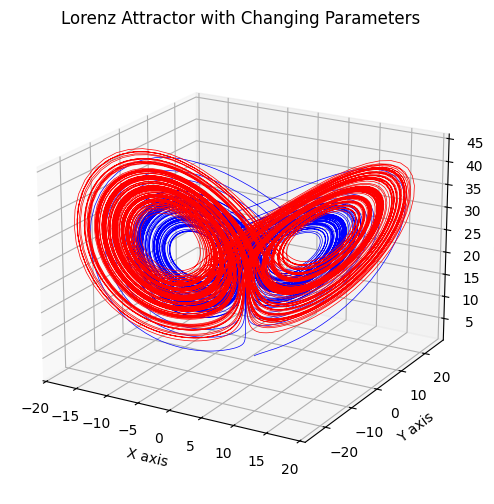

In [17]:
# Plotting the Lorenz attractor
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
m = int(len(t_eval)/2)
n = int(m/8)

ax.plot(data[:n, 0], data[:n, 1], data[:n, 2], lw=0.5,alpha=1.0, color='b')
ax.plot(data[m:m+n, 0], data[m:m+n, 1], data[m:m+n, 2], lw=0.5,alpha=1.0, color='r')

#ax.plot(data[:m, 0], data[:m, 1], data[:m, 2], lw=0.5,alpha=1.0, color='b')
#ax.plot(data[m:, 0], data[m:, 1], data[m:, 2], lw=0.5,alpha=1.0, color='r')

# Set plot labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('Lorenz Attractor with Changing Parameters')

#ax.set_xlim(-12, -11)
#ax.set_ylim(6, 8)
#ax.set_zlim(4, 8)



ax.view_init(elev=20, azim=300)
plt.savefig('lorenz.png')

plt.show()

In [20]:
# Step 3.1 Define the Neural Network Architecture
class FeedForward(nn.Module):
    def __init__(self, pars):
        super(FeedForward, self).__init__()
        self.input_size = pars['input_size']
        self.hidden_size = pars['hidden_size']
        self.output_size = pars['output_size']
        self.n = pars['n_layers']
        self.act_type = pars['activation']
        self.device = pars['device'] # Default to CPU if not specified

        if isinstance(self.hidden_size, Iterable) == False:
            self.hidden_size = [self.hidden_size] * self.n
        else:
            self.n = len(self.hidden_size)

        if self.act_type == 'tanh':
            self.act = nn.Tanh()
        elif self.act_type == 'sig':
            self.act = nn.Sigmoid()
        elif self.act_type == 'relu':
            self.act = nn.ReLU()

        self.fci = nn.Linear(self.input_size, self.hidden_size[0])

        self.linear_list = torch.nn.ModuleList()
        for k in range(self.n - 1):
            self.linear_list.append(torch.nn.Linear(self.hidden_size[k], self.hidden_size[k + 1]))

        self.fcf = nn.Linear(self.hidden_size[-1], self.output_size)

        self.to(self.device)  # Move the model to the specified device

    def forward(self, x):
        x = x.to(self.device)  # Move input to the specified device
        x = self.fci(x)
        for i in range(self.n - 1):
            x = self.act(x)
            x = self.linear_list[i](x)
        x = self.act(x)
        x = self.fcf(x)
        return x


# Define hyperparameters
training_pars = {
    'input_size': 3,
    'hidden_size': 50,
    'output_size': 3,
    'optimizer': 'Adam',
    'learning_rate': 0.001,
    'loss_func': 'mse',
    'n_layers': 4,
    'activation': 'tanh',
    'device': 'cpu'
}

num_simulations = 2
len_row = 50
lenght_losses = int((t_span[1] - t_span[0])/(dt*len_row))
# Initialize the loss lists
train_losses_D = np.zeros((num_simulations, lenght_losses-1))
train_losses_V = np.zeros((num_simulations, lenght_losses-1))
lyap_list_D = np.zeros((num_simulations, lenght_losses-1))
lyap_list_V = np.zeros((num_simulations, lenght_losses-1))

In [21]:
best_loss = 1000000

for m in range(num_simulations):
    # Step 4: Train the Neural Network
    model = FeedForward(training_pars)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = training_pars['learning_rate'])

    num_epochs = 1
    input_size = training_pars['input_size']
    num_steps = 10
    alpha = + 0

    train_losses = []
    test_losses = []
    lyap_list = []

    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(data) - len_row, len_row):
            optimizer.zero_grad()
            loss = 0
            for j in range(len_row):
                outputs = model(torch.tensor(data[i + j], dtype=torch.float32))
                loss += criterion(outputs, torch.tensor(data[i + j + 1], dtype=torch.float32))/len_row

            # Initial condition
            initial_condition = torch.rand((1, input_size)) * 2.0 - 1.0
            input = initial_condition.clone().requires_grad_(True)

            # Lyapunov exponent lists

            R_diag = torch.zeros(0, requires_grad=True)

            lyapunovs_sum = torch.zeros(num_steps, requires_grad=True)

            lyapunovs_list = torch.zeros(0, requires_grad=True)

            for k in range(num_steps):
            # Compute Jacobian matrix for the original trajectory
                jacobian_matrix = jacobian(model, input, create_graph=True)
                jacobian_matrix = torch.reshape(jacobian_matrix.clone(), (input_size, input_size))

                if torch.isnan(jacobian_matrix).any() or torch.isinf(jacobian_matrix).any():
                    # Handle NaN or Inf values in the Jacobian matrix
                    print(jacobian_matrix)
                    print(k, j, i)
                    print("Jacobian matrix contains NaN or Inf values. Training stopped.")
                    break

                Q, R = torch.linalg.qr(jacobian_matrix)
                if k == num_steps-1:
                    Q_last = Q
                R_diag = torch.cat( (R_diag, torch.diag(R)), dim = 0)

                # Update the trajectory
                input = model(input)

            #---------------------------Lyapunov Exponents---------------------------#
                reshaped_R_diag = R_diag.view(-1, 3)
                lyapunovs, indices = torch.sort(torch.mean(torch.log(torch.abs(reshaped_R_diag)), dim=0), descending=True)
                lyapunovs_list = torch.cat((lyapunovs_list, lyapunovs), dim = 0)
            # Averages of eigenvalues and Lyapunov exponents

            lyapunovs_1_list_mean = torch.sum(lyapunovs_list[0]) # Mean over steps of the Lyapunov exponents

            lyapunov_sum_mean = torch.sum(lyapunovs_list) # Mean over steps of the sum of the Lyapunov exponents

            loss += alpha * torch.abs(lyapunovs_1_list_mean) # Add the sum of the Lyapunov exponents to the loss function

            loss.backward()
            optimizer.step()


            train_losses.append(loss.item()-alpha*torch.abs(lyapunovs_1_list_mean).item())
            lyap_list.append(lyapunovs_1_list_mean.item())


            if i % 50000 == 0:
                print(i, loss.item()-alpha*torch.abs(lyapunovs_1_list_mean).item(), m)
            if np.isnan(loss.item()) or np.isinf(loss.item()):
                print("Loss contains NaN or Inf values. aaaaaaaaaa")


    if alpha != 0:
        train_losses_D[m] = np.array(train_losses)
        lyap_list_D[m] = np.array(lyap_list)
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_weights_D = model.state_dict()
    else:
        train_losses_V[m] = np.array(train_losses)
        lyap_list_V[m] = np.array(lyap_list)
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_weights_V = model.state_dict()

0 284.13519287109375 0
50000 33.64103698730469 0
100000 20.27734375 0
150000 10.246522903442383 0
200000 2.5865705013275146 0
0 284.5586853027344 1
50000 33.611698150634766 1
100000 23.419925689697266 1
150000 16.824729919433594 1
200000 2.391061782836914 1


In [23]:
best_loss = 1000000

for m in range(num_simulations):
    # Step 4: Train the Neural Network
    model = FeedForward(training_pars)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = training_pars['learning_rate'])

    num_epochs = 1
    input_size = training_pars['input_size']
    num_steps = 10
    alpha = + 0.1

    train_losses = []
    test_losses = []
    lyap_list = []

    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(data) - len_row, len_row):
            optimizer.zero_grad()
            loss = 0
            for j in range(len_row):
                outputs = model(torch.tensor(data[i + j], dtype=torch.float32))
                loss += criterion(outputs, torch.tensor(data[i + j + 1], dtype=torch.float32))/len_row

            # Initial condition
            initial_condition = torch.rand((1, input_size)) * 2.0 - 1.0
            input = initial_condition.clone().requires_grad_(True)

            # Lyapunov exponent lists

            R_diag = torch.zeros(0, requires_grad=True)

            lyapunovs_sum = torch.zeros(num_steps, requires_grad=True)

            lyapunovs_list = torch.zeros(0, requires_grad=True)

            for k in range(num_steps):
            # Compute Jacobian matrix for the original trajectory
                jacobian_matrix = jacobian(model, input, create_graph=True)
                jacobian_matrix = torch.reshape(jacobian_matrix.clone(), (input_size, input_size))

                if torch.isnan(jacobian_matrix).any() or torch.isinf(jacobian_matrix).any():
                    # Handle NaN or Inf values in the Jacobian matrix
                    print(jacobian_matrix)
                    print(k, j, i)
                    print("Jacobian matrix contains NaN or Inf values. Training stopped.")
                    break

                Q, R = torch.linalg.qr(jacobian_matrix)
                if k == num_steps-1:
                    Q_last = Q
                R_diag = torch.cat( (R_diag, torch.diag(R)), dim = 0)

                # Update the trajectory
                input = model(input)

            #---------------------------Lyapunov Exponents---------------------------#
                reshaped_R_diag = R_diag.view(-1, 3)
                lyapunovs, indices = torch.sort(torch.mean(torch.log(torch.abs(reshaped_R_diag)), dim=0), descending=True)
                lyapunovs_list = torch.cat((lyapunovs_list, lyapunovs), dim = 0)
            # Averages of eigenvalues and Lyapunov exponents

            lyapunovs_1_list_mean = torch.sum(lyapunovs_list[0]) # Mean over steps of the Lyapunov exponents

            lyapunov_sum_mean = torch.sum(lyapunovs_list) # Mean over steps of the sum of the Lyapunov exponents

            loss += alpha * torch.abs(lyapunovs_1_list_mean) # Add the sum of the Lyapunov exponents to the loss function

            loss.backward()
            optimizer.step()


            train_losses.append(loss.item()-alpha*torch.abs(lyapunovs_1_list_mean).item())
            lyap_list.append(lyapunovs_1_list_mean.item())


            if i % 50000 == 0:
                print(i, loss.item()-alpha*torch.abs(lyapunovs_1_list_mean).item(), m)
            if np.isnan(loss.item()) or np.isinf(loss.item()):
                print("Loss contains NaN or Inf values. aaaaaaaaaa")


    if alpha != 0:
        train_losses_D[m] = np.array(train_losses)
        lyap_list_D[m] = np.array(lyap_list)
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_weights_D = model.state_dict()
    else:
        train_losses_V[m] = np.array(train_losses)
        lyap_list_V[m] = np.array(lyap_list)
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_weights_V = model.state_dict()

0 286.2220598936081 0
50000 41.199906677007675 0
100000 0.6548932164907455 0
150000 1.6552598595619201 0
200000 0.4332713894546032 0
0 285.3894966840744 1
50000 37.29958338746801 1
100000 0.32468551844358445 1
150000 1.59115130007267 1
200000 1.1237659648060798 1


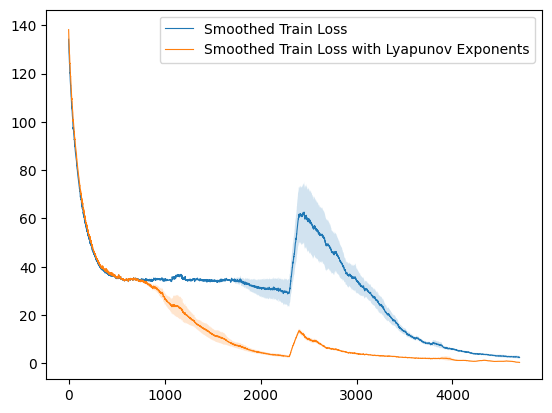

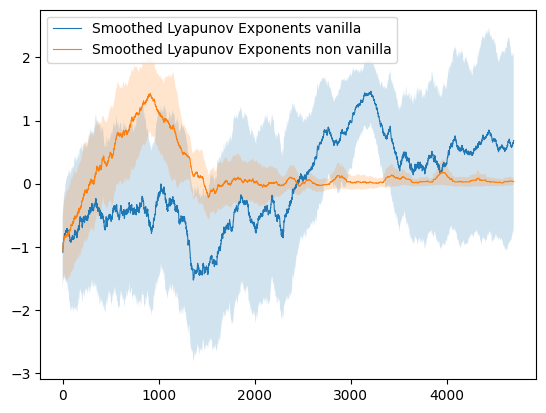

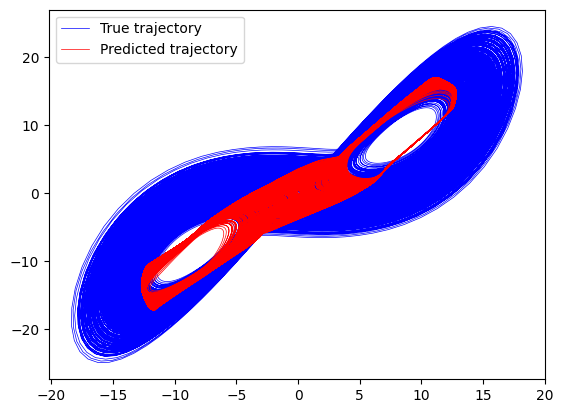

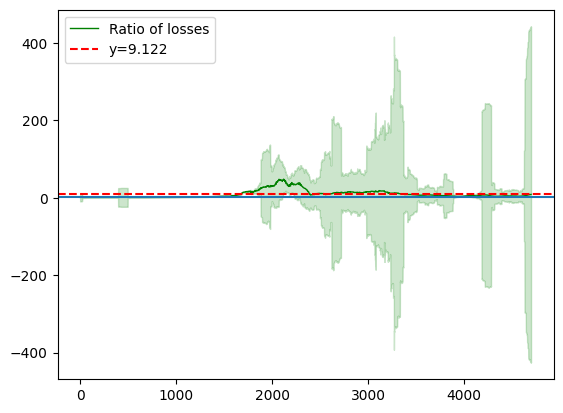

9.12170237841553


In [24]:
# Step 5: Evaluate the Model
begin = int(len(data)/2) +1
end   = int(begin*(1+ 0.5))

# Define a function to calculate the moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Convert the PyTorch tensors to numpy arrays for easier manipulation
train_losses_V_np = np.mean(train_losses_V, axis=0)
train_losses_V_np_std = np.std(train_losses_V, axis=0)
train_losses_D_np = np.mean(train_losses_D, axis=0)
train_losses_D_np_std = np.std(train_losses_D, axis=0)

lyap_list_V_np = np.mean(lyap_list_V, axis=0)
lyap_list_D_np = np.mean(lyap_list_D, axis=0)
lyap_list_V_np_std = np.std(lyap_list_V, axis=0)
lyap_list_D_np_std = np.std(lyap_list_D, axis=0)


# Define the window size for the moving average
window_size = 100

# Calculate the moving averages
smoothed_train_losses_V = moving_average(train_losses_V_np, window_size)
smoothed_train_std_V = moving_average(train_losses_V_np_std, window_size)

smoothed_train_losses_D = moving_average(train_losses_D_np, window_size)
smoothed_train_std_D = moving_average(train_losses_D_np_std, window_size)

smoothed_lyap_list_V = moving_average(lyap_list_V_np, window_size)
smoothed_lyap_list_D = moving_average(lyap_list_D_np, window_size)
smoothed_lyap_list_V_std = moving_average(lyap_list_V_np_std, window_size)
smoothed_lyap_list_D_std = moving_average(lyap_list_D_np_std, window_size)

smoothed_ratio = moving_average(train_losses_V_np/train_losses_D_np, window_size)
smoothed_ratio_std = moving_average(train_losses_V_np_std/train_losses_D_np_std, window_size)

ratio = smoothed_train_losses_V/smoothed_train_losses_D
ratio_std = train_losses_V_np_std/train_losses_D_np_std

# Create an array of x-axis values
# Adjust the length of the x-axis accordingly
x_axis = np.arange(len(smoothed_train_losses_D))

# Plot the smoothed arrays
#plt.yscale('log')
plt.plot(x_axis[:], smoothed_train_losses_V[:], label='Smoothed Train Loss', linewidth=0.8)
plt.fill_between(x_axis[:], smoothed_train_losses_V[:] - smoothed_train_std_V[:], smoothed_train_losses_V[:] + smoothed_train_std_V[:], alpha=0.2)
plt.plot(x_axis[:], smoothed_train_losses_D[:], label='Smoothed Train Loss with Lyapunov Exponents', linewidth=0.8)
plt.fill_between(x_axis[:], smoothed_train_losses_D[:] - smoothed_train_std_D[:], smoothed_train_losses_D[:] + smoothed_train_std_D[:], alpha=0.2)
plt.legend()
plt.show()

plt.figure()
#plt.yscale('log')
x_axis = np.arange(len(smoothed_lyap_list_D))
plt.plot(x_axis[:], smoothed_lyap_list_V[:], label='Smoothed Lyapunov Exponents vanilla', linewidth=0.8)
plt.fill_between(x_axis[:], smoothed_lyap_list_V[:] - smoothed_lyap_list_V_std[:], smoothed_lyap_list_V[:] + smoothed_lyap_list_V_std[:], alpha=0.2)
plt.plot(x_axis[:], smoothed_lyap_list_D[:], label='Smoothed Lyapunov Exponents non vanilla', linewidth=0.8)
plt.fill_between(x_axis[:], smoothed_lyap_list_D[:] - smoothed_lyap_list_D_std[:], smoothed_lyap_list_D[:] + smoothed_lyap_list_D_std[:], alpha=0.2)
plt.legend()
plt.show()

# Predict on test data
model = FeedForward(training_pars)
model.load_state_dict(best_weights_V)
model.eval()
data_torch = torch.tensor(data, dtype=torch.float32)
input_dim = training_pars['input_size']
with torch.no_grad():
    y_pred = model(data_torch.view(-1, input_dim)).numpy()

# Plot true vs predicted trajectories
plt.figure()
plt.plot(data[begin:end, 0], data[begin:end, 1], label='True trajectory', color='blue', linewidth = 0.5)
plt.plot(y_pred[begin:end, 0], y_pred[begin:end, 1], label='Predicted trajectory', color='red', linewidth=0.5)
plt.legend()
plt.show()


# ratio losses
plt.figure()
#plt.yscale('log')
plt.plot(smoothed_ratio, label='Ratio of losses', linewidth=1.0, color='green')
plt.fill_between(x_axis, smoothed_ratio - smoothed_ratio_std, smoothed_ratio + smoothed_ratio_std, alpha=0.2, color='green')
plt.axhline(y=np.mean(train_losses_V_np[:]/train_losses_D_np[:]), color='r', linestyle='--', label='y={:.3f}'.format(np.mean(train_losses_V_np[:]/train_losses_D_np[:])))
plt.axhline(y=1)

plt.legend()
plt.show()

print(np.mean(train_losses_V_np[:]/train_losses_D_np[:]))